In [2]:
import os
import sys
import matplotlib.pyplot as plt
import torch
from torch.utils.data import  DataLoader
import torchvision.utils as vutils
import torch.optim as optim
import torch.autograd as autograd
from ImageAestheticsGANs.AADB.AADB import AADB_binaries, AADB
from ImageAestheticsGANs.TheSUN.SUN import SUN
from ImageAestheticsGANs.models.ACGAN import Generator, Discriminator
# from models.cGAN import Generator, Discriminator
from ImageAestheticsGANs.utils.utils import *
from ImageAestheticsGANs.models.ResNet18 import RegressionNetwork
import torch.nn as nn

import torchvision.transforms as T
from PIL import Image

### Variables

In [3]:
batch_size = 128
max_epochs = 1200
latent_dim = 128
n_channels = 3
image_size = 128
ngf = 128   # feature map gen
ndf = 128   # feature map disc
beta = 0.5  # Adam
lrg = 0.0005  # Learning rate for optimizers
lrd = 0.0001
is_load = False
ckpt_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\cGAN_128x128\checkpoint_iteration_195000.tar'  # to set if checkpoint

In [4]:
n_critic = 5
lam_gp = 10

### AADB

In [5]:
data_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'
samples_path = "F:\Projects\Disertatie\ImageAestheticsGANs\cGAN_64x64"
os.makedirs(samples_path, exist_ok=True)

In [6]:
aadb = AADB_binaries(data_path)
aadb_test = AADB_binaries(data_path, test=True)
n_classes = aadb.get_num_classes()
n_classes

4

In [11]:
# sun = SUN()

tensor([0, 0, 0, 1])


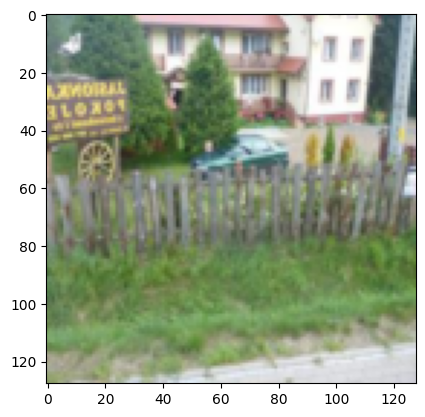

8958

In [12]:
show_example(*aadb[0])
len(aadb)

tensor([1, 0, 1, 0])


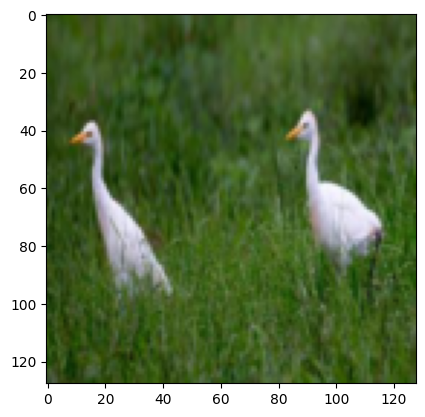

1000

In [13]:
show_example(*aadb_test[0])
len(aadb_test)

In [14]:
# show_example(*sun[2056])

In [15]:
aadb = aadb + aadb_test

In [16]:
len(aadb)

9958

### Dataloaders

In [17]:
train_dl = DataLoader(aadb, batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

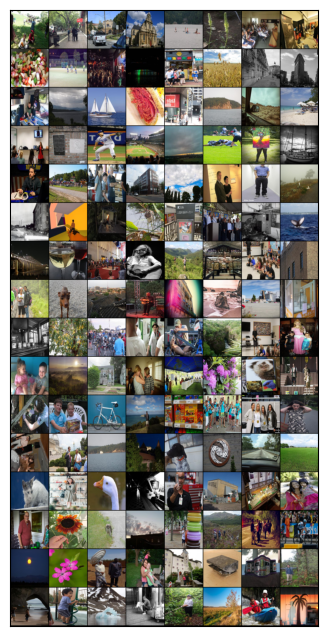

In [18]:
show_batch(train_dl)

In [19]:
for image, labels in train_dl:
    print(image.shape)
    print(type(labels))
    print(labels.shape)
    break

torch.Size([128, 3, 128, 128])
<class 'torch.Tensor'>
torch.Size([128, 4])


In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Sample Noise

In [16]:
n_sample = 64

sample_noise = torch.randn(n_sample, latent_dim, device=device)
sample_labels = torch.zeros(n_sample, n_classes, dtype=torch.float32, device=device)

for i in range(n_sample):
    label_init = torch.randint(2, (n_classes,), dtype=torch.float32, device=device)
    for j in range(len(label_init)):
        sample_labels[i][j] = label_init[j]
        if j == n_classes-1:
            sample_labels[i][j] = 1

## Initialize weigths

In [14]:
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

### Models and Loss

In [9]:
net_G = Generator(ngf, n_classes, image_size, n_channels, latent_dim).to(device)
net_D = Discriminator(ndf, n_channels, image_size, n_classes).to(device)

In [16]:
net_G.apply(weights_init)
net_D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LayerNorm((256, 16, 16), eps=1e-05, elementwise_affine=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): LayerNorm((512, 8, 8), eps=1e-05, elementwise_affine=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LayerNorm((1024, 4, 4), eps=1e-05, elementwise_affine=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Reshape()
  )
  (adv): Sequential(
    (0): Linear(in_features=16384, out_features=1, bias=True)
  )
  (aux): Sequential(
    (0): Linear(in_features=16384, out_features=4, bias=

In [21]:
print(net_G)
print(net_D)

Generator(
  (exp): Linear(in_features=8, out_features=28, bias=True)
  (main): Sequential(
    (0): Linear(in_features=156, out_features=16384, bias=True)
    (1): Reshape()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [22]:
def MBCE(input, target, esp=1e-19):
    loss = - torch.mean(target * torch.log(input.clamp_min(esp))) - torch.mean(
        (1 - target) * torch.log((1 - input).clamp_min(esp)))
    return loss

In [23]:
optimizer_D = optim.Adam(net_D.parameters(), lr=lrd, betas=(beta, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lrg, betas=(beta, 0.999))

In [24]:
def gradient_penalty(x, y, f):
    # interpolation
    shape = [x.size(0)] + [1] * (x.dim() - 1)
    alpha = torch.rand(shape, device=device)
    z = x + alpha * (y - x)

    z.requires_grad = True
    o = f(z)[0]
    ones = torch.ones(o.size(), device=device)
    g = autograd.grad(o, z, grad_outputs=ones, create_graph=True)[0].view(z.size(0), -1)
    gp = ((g.norm(p=2, dim=1) - 1) ** 2).mean()

    return gp

In [25]:
def save_diagram_loss(list_1, list_2,
                 label1="D", label2="G",
                 title="Generator and Discriminator loss During Training",
                 x_label="iterations", y_label="Loss",
                 path=samples_path,
                 name='loss.jpg'
                 ):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(list_1, label=label1)
    plt.plot(list_2, label=label2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.savefig(os.path.join(path, name))
    plt.close()

# Train V1

In [28]:
if is_load:
    print("Loading checkpoint...")

    checkpoint = torch.load(ckpt_path)
    last_epoch = checkpoint['epoch']
    iteration = checkpoint['iteration']
    last_i = checkpoint['last_current_iteration']
    sample_noise = checkpoint['sample_noise']

    list_loss_D = checkpoint['list_loss_D']
    list_loss_G = checkpoint['list_loss_G']

    loss_D = list_loss_D[-1]
    loss_G = list_loss_G[-1]

    net_D.load_state_dict(checkpoint['netD_state_dict'])
    net_G.load_state_dict(checkpoint['netG_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    net_D.eval()
    net_G.eval()

else:
    last_epoch = 0
    iteration = 0

    list_loss_G = []
    list_loss_D = []

print("Starting Training Loop...")
for epoch in range(last_epoch, max_epochs):
    str_i = 0
    if is_load:
        str_i = last_i
    for i, (real_img, real_c) in enumerate(train_dl, str_i):

        # -----------------------------------------------------------
        # Initial batch
        real_img, real_c = real_img.to(device), real_c.to(device)
        real_batch_size = real_img.size(0)
        noise = torch.randn(real_batch_size, latent_dim, device=device)
        # random label
        fake_c = torch.randint(2, (real_batch_size, n_classes), dtype=torch.float32, device=device)
        fake_img = net_G(noise, fake_c)

        # -----------------------------------------------------------
        # Update D network: minimize: -(D(x) - D(G(z)))+ lambda_gp * gp + class_loss (gradient penalty)
        net_D.zero_grad()

        v, c = net_D(real_img)
        loss_real = (- torch.mean(v) + MBCE(c, real_c)) * 0.5
        v, c = net_D(fake_img.detach())
        loss_fake = (torch.mean(v) + MBCE(c, fake_c)) * 0.5
        gp = gradient_penalty(real_img.detach(), fake_img.detach(), net_D)
        loss_D = (loss_real + loss_fake) * 0.5 + lam_gp * gp  # total loss of D

        # Update D
        loss_D.backward()
        optimizer_D.step()

        # -----------------------------------------------------------
        # Update G network: maximize D(G(z)) , equal to minimize - D(G(z))
        if i % n_critic == 0:
            net_G.zero_grad()

            # Calculate G loss
            v, c = net_D(fake_img)

            loss_G = (- torch.mean(v) + MBCE(c, fake_c)) * 0.5

            # Update G
            loss_G.backward()
            optimizer_G.step()

        # -----------------------------------------------------------
        # Output training stats
        with torch.no_grad():
            list_loss_D.append(loss_D.item())

            if type(loss_G) == float:
                list_loss_G.append(loss_G)
            else:
                list_loss_G.append(loss_G.item())

            if i % 100 == 0: # batches
                print(
                    '[%d/%d][%2d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch, max_epochs, i, len(train_dl),
                       list_loss_D[-1], list_loss_G[-1]))

            # Output sample noise
            if (iteration % 500 == 0) or ((epoch == max_epochs - 1) and (i == len(train_dl) - 1)):
                samples = net_G(sample_noise, sample_labels).cpu()
                vutils.save_image(samples, os.path.join(samples_path, '%d.jpg' % iteration), padding=2, normalize=True)
                save_diagram_loss(list_loss_D, list_loss_G, name='loss.jpg')

            # Save model after 5000 iterations
            if (iteration % 5000 == 0) or ((epoch == max_epochs - 1) and (i == len(train_dl) - 1)):
                save_path = os.path.join(samples_path, 'checkpoint_iteration_%d.tar' % iteration)
                torch.save({
                    'epoch': epoch,
                    'iteration': iteration,
                    'last_current_iteration': i,
                    'netD_state_dict': net_D.state_dict(),
                    'netG_state_dict': net_G.state_dict(),
                    'optimizer_D_state_dict': optimizer_D.state_dict(),
                    'optimizer_G_state_dict': optimizer_G.state_dict(),
                    'list_loss_D': list_loss_D,
                    'list_loss_G': list_loss_G,
                    'sample_noise': sample_noise
                }, save_path)

        # iteration: total iteration, i: iteration of current epoch
        iteration += 1
        is_load = False

Loading checkpoint...
Starting Training Loop...
[599/1200][100/77]	Loss_D: -0.0570	Loss_G: 0.2763
[600/1200][ 0/77]	Loss_D: -0.0112	Loss_G: 2.7289
[601/1200][ 0/77]	Loss_D: 0.3278	Loss_G: 0.7713
[602/1200][ 0/77]	Loss_D: 0.2439	Loss_G: 2.2374
[603/1200][ 0/77]	Loss_D: 0.4318	Loss_G: 1.3010
[604/1200][ 0/77]	Loss_D: 0.3676	Loss_G: -2.5385
[605/1200][ 0/77]	Loss_D: -0.0622	Loss_G: 0.8107
[606/1200][ 0/77]	Loss_D: 0.1619	Loss_G: 1.7439
[607/1200][ 0/77]	Loss_D: 0.1445	Loss_G: 1.4048
[608/1200][ 0/77]	Loss_D: 0.0198	Loss_G: 2.6359
[609/1200][ 0/77]	Loss_D: 0.3533	Loss_G: -0.9663
[610/1200][ 0/77]	Loss_D: 0.3194	Loss_G: 1.7027
[611/1200][ 0/77]	Loss_D: 0.1237	Loss_G: 1.7250
[612/1200][ 0/77]	Loss_D: 0.1644	Loss_G: -0.0221
[613/1200][ 0/77]	Loss_D: 0.3305	Loss_G: 0.4543
[614/1200][ 0/77]	Loss_D: 0.3196	Loss_G: 0.5794
[615/1200][ 0/77]	Loss_D: 0.0593	Loss_G: 1.1031
[616/1200][ 0/77]	Loss_D: 0.1535	Loss_G: -0.2267
[617/1200][ 0/77]	Loss_D: 0.0999	Loss_G: -0.3998
[618/1200][ 0/77]	Loss_D: 0.321

# Testing

In [10]:
testing_model = RegressionNetwork(backbone='resnet18', num_attributes=n_classes, pretrained=True)
testing_model = testing_model.to('cuda')
testing_model.load_state_dict(torch.load("F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt\AADB_epoch_41_loss_0.6305_.pt")['model'])
testing_model.eval()

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [11]:
checkpoint = torch.load(ckpt_path)
gen = Generator(ngf, n_classes, image_size, n_channels, latent_dim).to('cuda')
gen.load_state_dict(checkpoint['netG_state_dict'])
gen.eval()

Generator(
  (exp): Linear(in_features=4, out_features=28, bias=True)
  (main): Sequential(
    (0): Linear(in_features=156, out_features=65536, bias=True)
    (1): Reshape()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [131]:
sample_noise = torch.randn(1, latent_dim, device=device)
# test_labels = torch.randint(5, (n_classes,), dtype=torch.float32, device=device).view(1,n_classes)
test_labels = torch.tensor([1, 1, 1, 1], dtype=torch.float32, device=device)

In [132]:
sample = gen(sample_noise, test_labels.view(1,n_classes)).squeeze().cpu().detach()
vutils.save_image(sample, os.path.join("F:\Projects\Disertatie", 'test.jpg'), normalize=True)

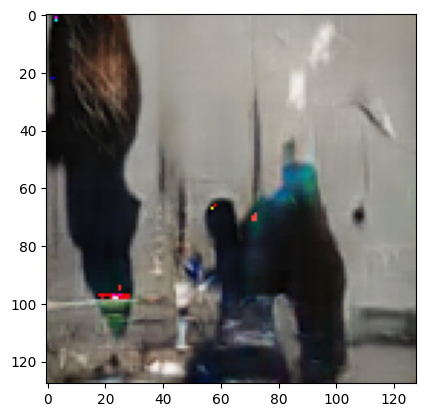

In [133]:
plt.imshow(to_pil(sample))

In [135]:
sample_tensor = sample.to("cuda").unsqueeze(0)
y_pred = testing_model(sample_tensor)
predicted = y_pred > 0.5
predicted = predicted.cpu().detach().numpy()
y = test_labels.cpu().numpy()

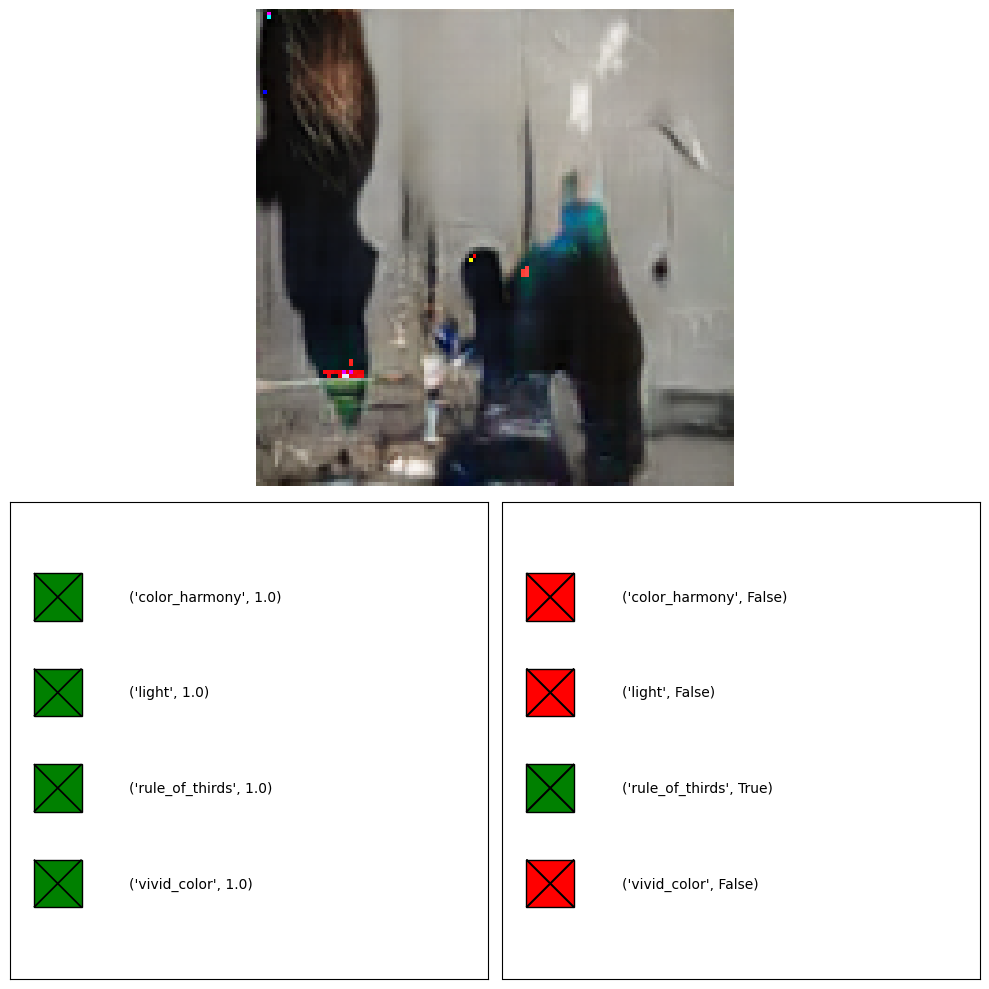

In [136]:
display_aesthetics(sample, y, predicted, interval=[0, 0], score=False)

In [356]:
sample_noise = torch.randn(1, latent_dim, device=device)
test_labels = torch.tensor([1, 1, 1, 1], dtype=torch.float32, device=device)
samples = gen(sample_noise, test_labels.view(1,n_classes)).cpu()
vutils.save_image(samples, os.path.join("F:\Projects\Disertatie", 'test.jpg'), normalize=True)

In [357]:
# samples.unsqueeze(0).shape

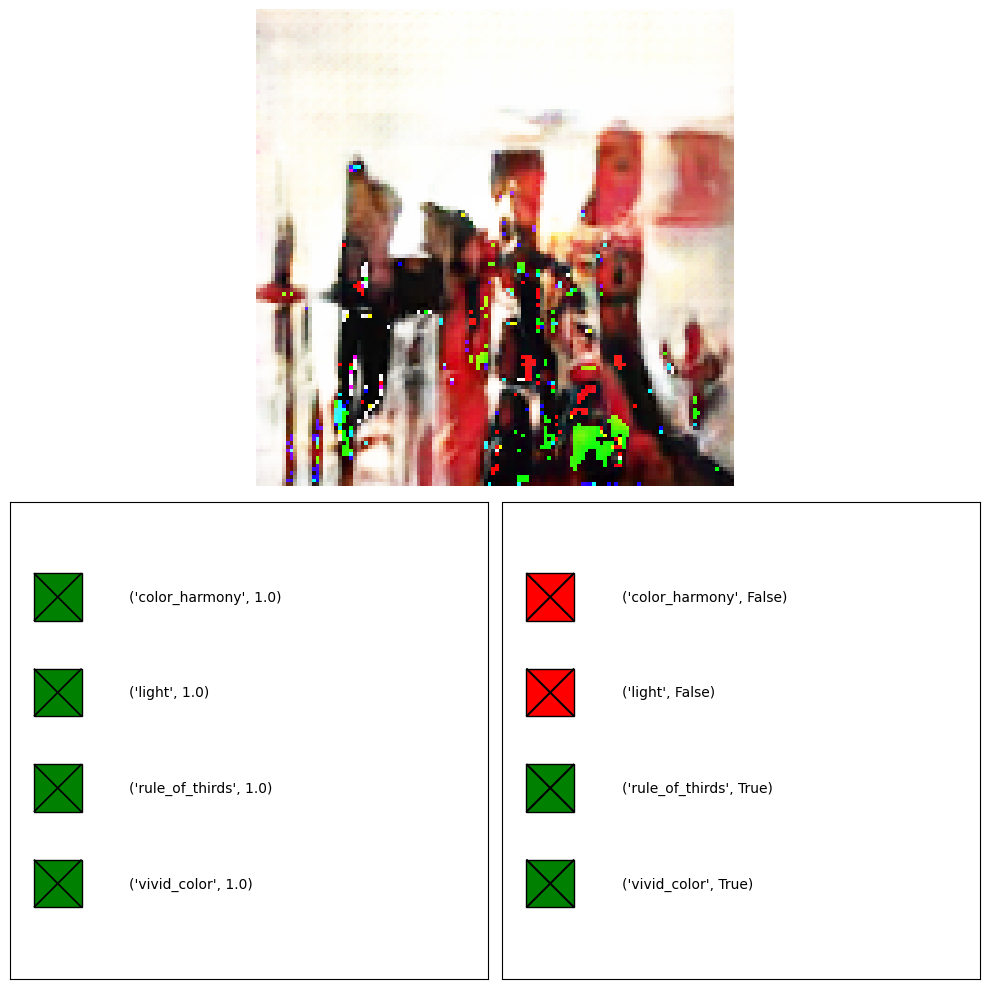

In [358]:
image_read = Image.open("F:\Projects\Disertatie\\test.jpg").convert('RGB')
transforms = T.ToTensor()
sample_tensor = transforms(image_read).unsqueeze(0).to('cuda')
y_pred = testing_model(sample_tensor)
predicted = y_pred > 0.5
predicted = predicted.cpu().detach().numpy()
y = test_labels.cpu().numpy()
display_aesthetics(samples.squeeze().cpu().detach(), y, predicted, interval=[0, 0], score=False)